In [239]:
import numpy as np  
import matplotlib.pyplot as plt
from scipy.signal import convolve, fftconvolve
from scipy.special import erfc

In [240]:

num_bits = 100              # number of bits will send
num_samples_per_bit = 20    # number of sample to convert it to continouse
Ts = 1                      # discrete sampling time
A = 1                       # amplitude of signal
g1_t = A * np.ones(num_samples_per_bit) # pulse shape when "1" was sent
g1_t_norm = np.linalg.norm(g1_t, axis=0) # for normalizaton 1/sqrt(num_sample_per_bits)
print(1/g1_t_norm)
print(1/np.sqrt(num_samples_per_bit))

0.22360679774997896
0.22360679774997896


## Part 1

### Matched Filter
$$
    \text{received signal from channel} = r(t) = g(t) + w(t) \\
    \text{output filter} = y(t)  = r(t) \ast h(t) = g_o(t) + n(t) \\
    \text{filter} = h(t) = k * g(T - t) \\
$$

In [241]:
def generate_bipolar_NRT_sig(data: np.ndarray, num_samples_per_bit = num_samples_per_bit):
    """
    parameters:
        data: binary array of shape num_bits
    return:
        time: numpy array represent time axis
        g_t : output signal from transmitter
    """
    g_t = np.repeat(data, num_samples_per_bit) # repeat every data point "num_samples_per_bit" [010] => [0000111110000]
    g_t = ((g_t * 2) - 1) # convert 0 -> -A | 1 -> A
    return g_t / g1_t_norm



def generate_match_filter(g1_t: np.ndarray, num_bits = num_bits, num_samples_per_bit = num_samples_per_bit):
    # g1_t : impulse shape when sending "1" must be in shape (num_samples_per_bit, )
    h_t = g1_t[::-1] # just reverse it
    h_t = np.concatenate([h_t, np.zeros((num_bits - 1) * num_samples_per_bit)]) # adding zeros till match shape of g_t
    return h_t

def generate_pulse_filter(num_bits = num_bits, num_samples_per_bit = num_samples_per_bit):
    h_t = np.zeros((num_bits * num_samples_per_bit)) # just reverse it
    h_t[0] = 1
    return h_t

def generate_filter_p3(num_bits = num_bits, num_samples_per_bit = num_samples_per_bit):
    h_t = np.arange(0, num_samples_per_bit, dtype=np.float64)
    h_t *= np.sqrt(3)
    h_t = np.concatenate([h_t, np.zeros((num_bits - 1) * num_samples_per_bit)]) 
    return h_t
 

def generate_AWGN(No: int, num_bits = num_bits, num_samples_per_bit = num_samples_per_bit):
    noise = np.random.normal(0, No/2, size=(num_bits * num_samples_per_bit,))
    return noise


In [242]:
data = np.array([0, 1, 1])
g_t = generate_bipolar_NRT_sig(data) 
h_t = generate_match_filter(np.ones(num_samples_per_bit) * A, 3)
y_t = convolve(g_t, h_t) # ignoring noise return the same shape of g(t)

In [243]:
g_t.shape, h_t.shape, y_t.shape

((60,), (60,), (119,))

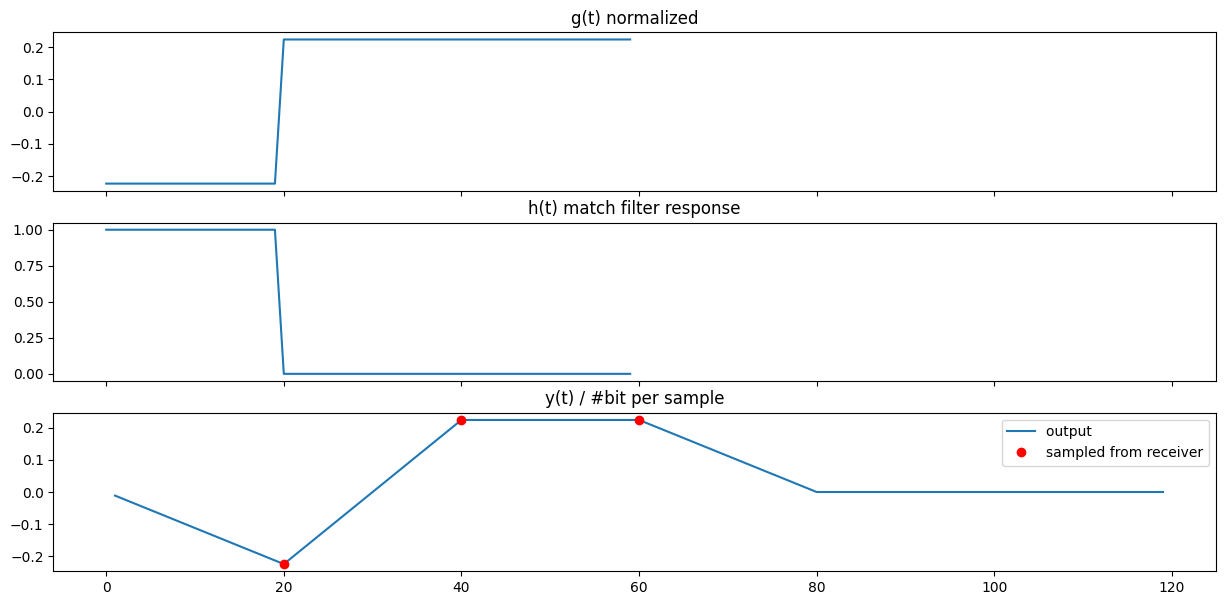

In [244]:
fig, axs = plt.subplots(3, 1, figsize=(15, 7), sharex=True)
clock = (np.arange(3) + 1) * num_samples_per_bit

axs[0].set_title("g(t) normalized")
axs[0].plot(g_t)

axs[1].set_title("h(t) match filter response")
axs[1].plot(h_t)


axs[2].set_title("y(t) / #bit per sample")
axs[2].plot(np.arange(1, len(y_t)+1), y_t / num_samples_per_bit, label = "output " ) # convolution shifted at boundries 
axs[2].plot(clock, y_t[clock-1] / num_samples_per_bit, "ro", label = "sampled from receiver")

plt.legend()
plt.show()


# Part 2

In [245]:

# channel jop
def generate_random_signal(num_bits,  No = 2, num_samples_per_bit = num_samples_per_bit):
    data =  np.random.choice([0, 1], size=(num_bits), p=[1./2, 1./2])
    g_t = generate_bipolar_NRT_sig(data, num_samples_per_bit) 
    w_t = generate_AWGN(No, num_bits, num_samples_per_bit) 

    return data, g_t, w_t
    
# receiver jop
def get_reciver_ouput(r_t, filter_type = "match", num_samples_per_bit = num_samples_per_bit):
    
    h_t = None
    
    if filter_type == "match":
        h_t = generate_match_filter(g1_t, num_bits, num_samples_per_bit)
    elif filter_type == "pulse":
        h_t = generate_pulse_filter(num_bits, num_samples_per_bit)
    else:
        h_t = generate_filter_p3(num_bits, num_samples_per_bit)
        
    y_t = convolve(r_t, h_t) 
    
  
    return h_t, y_t


In [246]:
data, g_t, w_t = generate_random_signal(num_bits, No = 2)
r_t = g_t + w_t
h_t_match, y_t_match = get_reciver_ouput(r_t, "match")
h_t_pulse, y_t_pulse = get_reciver_ouput(r_t, "pulse")
h_t_p3, y_t_p3 = get_reciver_ouput(r_t, "p3")


In [247]:
clock = (np.arange(num_bits) + 1) * num_samples_per_bit 
y_t_match_sampled = y_t_match[clock-1]
y_t_pulse_sampled = y_t_pulse[clock-1]
y_t_p3_sampled = y_t_p3[clock-1]

In [248]:
y_t_match_sampled.shape, r_t.shape, clock.shape

((100,), (2000,), (100,))

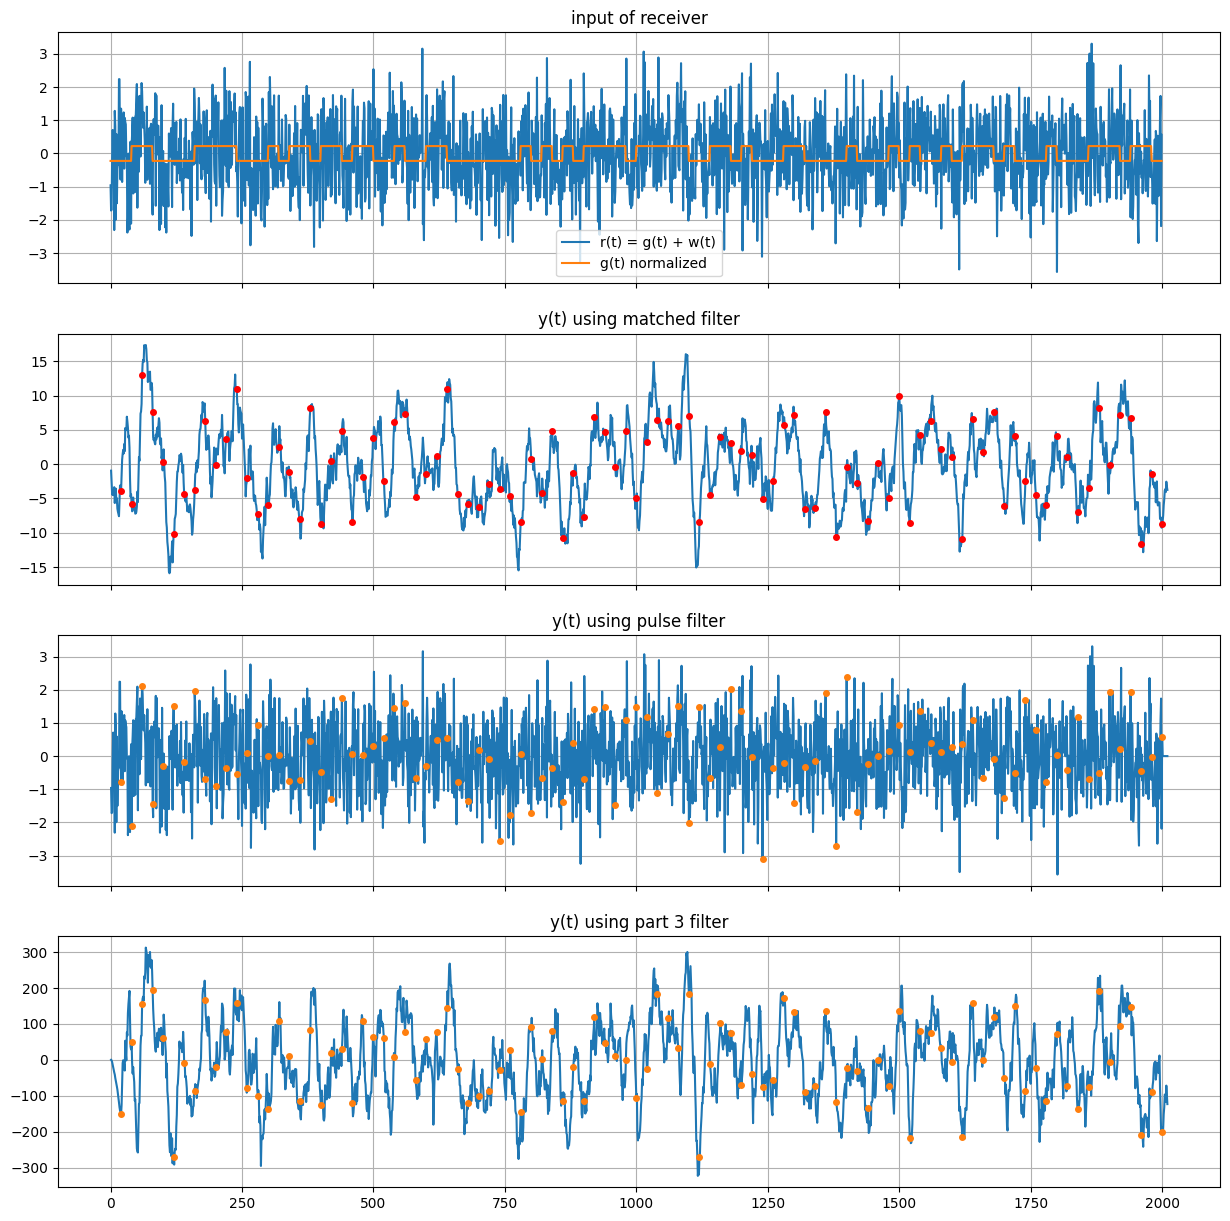

In [249]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)
show_bound = len(g_t) + 10


axs[0].set_title("input of receiver")
axs[0].plot(r_t, label="r(t) = g(t) + w(t)")
axs[0].plot(g_t, label="g(t) normalized")
axs[0].grid(True)
axs[0].legend()

axs[1].set_title("y(t) using matched filter")
axs[1].plot(np.arange(1, show_bound + 1), y_t_match[:show_bound]) # convolution shifted at boundries 
axs[1].plot(clock, y_t_match_sampled, "ro", markersize=4)
axs[1].grid(True)


axs[2].set_title("y(t) using pulse filter")
axs[2].plot(np.arange(1, show_bound + 1), y_t_pulse[:show_bound] ) # convolution shifted at boundries 
axs[2].plot(clock, y_t_pulse_sampled, "o", markersize=4)
axs[2].grid(True)


axs[3].set_title("y(t) using part 3 filter")
axs[3].plot(np.arange(1, show_bound + 1), y_t_p3[:show_bound]) # convolution shifted at boundries 
axs[3].plot(clock, y_t_p3_sampled, "o", markersize=4)
axs[3].grid(True)

plt.show()


$$
\text{ Matched Filter }\\ 
P(\text{error}) = 0.5 * \text{erfc}(A \sqrt{\frac{T}{N_o}}) = 0.5 * \text{erfc}(\sqrt{\frac{E}{N_o}}) \\
E = A^2 * T \\
\\
\\
\text{ No Filter }\\ 
P(\text{error}) = 0.5 * \text{erfc}(\frac{A}{\sqrt{N_o}}) = 0.5 * \text{erfc}(\frac{E}{\sqrt{N_o}}) \\
E = A \\
\\
\text{ Ramp Filter }\\ 
P(\text{error}) = 0.5 * \text{erfc}(\frac{\sqrt{3}A}{2}. \sqrt{\frac{T}{N_o}}) = 0.5 * \text{erfc}(\frac{E}{\sqrt{T N_o}}) \\
E = \frac{\sqrt{3}}{2}.A.T
$$

In [424]:
def calc_sim_BER(data, sampled_received):
    error_prob = np.sum(data != sampled_received)
    error_prob /= data.shape[0]
    return error_prob

def calc_theo_BER(A, No, T, filter_type="match"):
    if filter_type == "match":
        return 0.5 * erfc(  A * np.sqrt(T / No ) ) 
    elif filter_type == "pulse":
        return 0.5 * erfc(  A / np.sqrt(No )  )
    else:
        return 0.5 * erfc( (np.sqrt(3) / 2) * A * ( np.sqrt(T / No))  )


In [429]:
num_bits = 10**5

BER_simulated_match = []
BER_theortical_match = []

BER_simulated_pulse = []
BER_theortical_pulse = []

BER_simulated_p3 = []
BER_theortical_p3 = []

E = 1

data =  np.random.choice([0, 1], size=(num_bits), p=[1./2, 1./2])
g_t = generate_bipolar_NRT_sig(data)
AA = 1 / g1_t_norm
TT = num_samples_per_bit

for E_div_No_db in range(-10, 21): 
    E_div_No = 10 ** (E_div_No_db/10)
    No = E / E_div_No
    
    w_t = generate_AWGN(No, num_bits, num_samples_per_bit) 
    r_t = g_t + w_t 
    
    h_t_match, y_t_match = get_reciver_ouput(r_t, "match", num_samples_per_bit)
    h_t_pulse, y_t_pulse = get_reciver_ouput(r_t, "pulse", num_samples_per_bit)
    h_t_p3, y_t_p3 = get_reciver_ouput(r_t, "p3", num_samples_per_bit)
    
    # sampling
    clock = (np.arange(num_bits) + 1) * num_samples_per_bit 
    y_t_match_sampled = (y_t_match[clock-1] > 0).astype(int)
    y_t_pulse_sampled = (y_t_pulse[clock-1] > 0).astype(int)
    y_t_p3_sampled = (y_t_p3[clock-1] > 0).astype(int)
    
    
    # print(f"========= for E/No = {E_div_No_db} =======")
    # print(y_t_match_sampled, calc_sim_BER(data, y_t_match_sampled), calc_theo_BER(No, num_samples_per_bit, "match"))
    # print(y_t_pulse_sampled, calc_sim_BER(data, y_t_pulse_sampled), calc_theo_BER(No, num_samples_per_bit, "pulse"))
    # print(y_t_p3_sampled, calc_sim_BER(data, y_t_p3_sampled), calc_theo_BER(No, num_samples_per_bit, "p3"))
    BER_simulated_match.append(calc_sim_BER(data, y_t_match_sampled))
    BER_theortical_match.append(calc_theo_BER(AA, No, TT, "match"))
    
    
    BER_simulated_pulse.append(calc_sim_BER(data, y_t_pulse_sampled))
    BER_theortical_pulse.append(calc_theo_BER(AA, No, TT, "pulse"))
    
    BER_simulated_p3.append(calc_sim_BER(data, y_t_p3_sampled))
    BER_theortical_p3.append(calc_theo_BER(AA, No, TT,  "p3"))

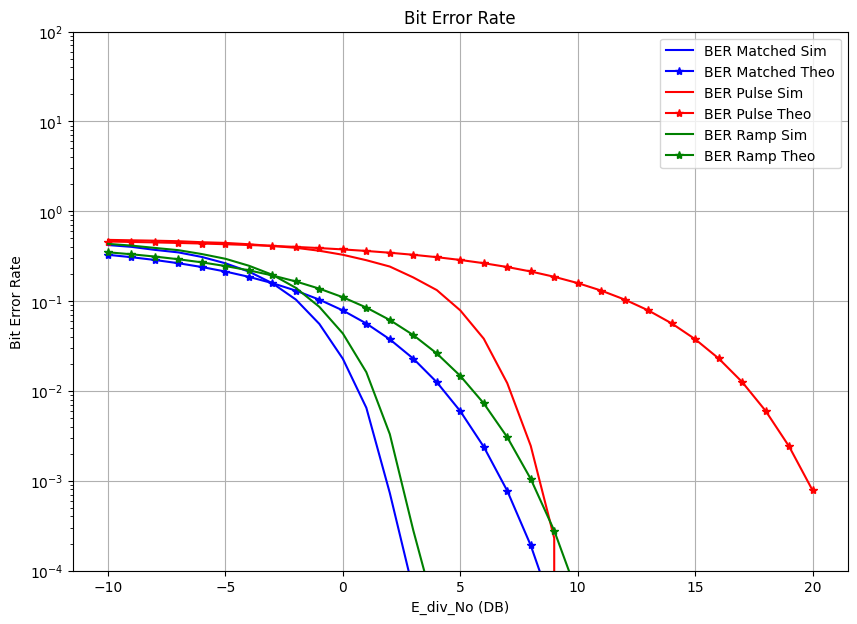

In [431]:
plt.figure(figsize=(10, 7))
plt.plot(range(-10, 21), BER_simulated_match, 'b', label="BER Matched Sim")
plt.plot(range(-10, 21), BER_theortical_match, 'x-b', label="BER Matched Theo")


plt.plot(range(-10, 21), BER_simulated_pulse, 'r',  label="BER Pulse Sim")
plt.plot(range(-10, 21), BER_theortical_pulse, 'x-r', label="BER Pulse Theo")

plt.plot(range(-10, 21), BER_simulated_p3, 'g',  label="BER Ramp Sim")
plt.plot(range(-10, 21), BER_theortical_p3, 'x-g', label="BER Ramp Theo")

plt.xlabel('E_div_No (DB)')
plt.ylabel('Bit Error Rate')
plt.yscale('log')
plt.ylim(10**(-4), 10**2)
plt.title('Bit Error Rate')
plt.legend()
plt.grid()
plt.show()

-0.22360679774997896

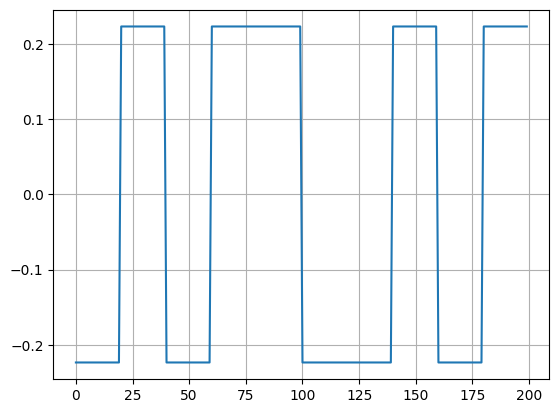

In [ ]:
plt.plot(g_t[:200])
plt.grid()
g_t[0]

In [ ]:
AA

0.22360679774997896

In [ ]:
go_t_match = convolve(g_t, h_t_match)
go_t_match = (go_t_match > 0).astype(np.int32)

In [171]:
np.sum(go_t_match * go_t_match) / len(go_t_match)

0.48425512106378027

In [172]:
go_t_match.shape

(3999999,)